#DATASCI W261: Machine Learning at Scale

**Nick Hamlin** (nickhamlin@gmail.com)  
**Tigi Thomas** (tgthomas@berkeley.edu)  
**Rock Baek** (rockb1017@gmail.com)  
**Hussein Danish** (husseindanish@gmail.com)  
  
Time of Submission: 9:00 AM EST, Tuesday, April 5, 2016  
W261-3, Spring 2016  
Week 10 Homework

###Submission Notes:
- For each problem, we've included a summary of the question as posed in the instructions.  In many cases, we have not included the full text to keep the final submission as uncluttered as possible.  For reference, we've included a link to the original instructions in the "Useful Reference" below.
- Some aspects of this notebook don't always render nicely into PDF form.  In these situations, please reference [the complete rendered notebook on Github](https://github.com/nickhamlin/mids_261_homework/blob/master/HW10/MIDS-W261-2015-HWK-Week10-Hamlin-Thomas-Baek-Danish.ipynb)


###Useful References and Notebook Setup:
- **[Original Assignment Instructions](https://www.dropbox.com/sh/jl4bsm17jiqd463/AAC2IYsxR8VDNsDsW6rJRnfPa/MIDS-MLS-HW-10.txt?dl=0)**
- [Word count examples in Spark](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/c2jgogq8tbuqjry/MIDS-Lecture-10-Spark-IntroductoryExamples.ipynb)
- [KMeans data](https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0)
- [KMeans Notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb)

In [25]:
#Use this to make sure we reload the MrJob code when we make changes
%load_ext autoreload
%autoreload 2
#Render matplotlib charts in notebook
%matplotlib inline

#Import some modules we know we'll use frequently
import numpy as np
import pylab as plt

In [2]:
import os
import sys #current as of 9/26/2015
spark_home = os.environ['SPARK_HOME'] = \
   '/Users/nicholashamlin/spark-1.6.1-bin-hadoop2.6/'

if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.9-src.zip'))
execfile(os.path.join(spark_home,'python/pyspark/shell.py'))
 

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.6.1
      /_/

Using Python version 2.7.10 (default, Oct 19 2015 18:31:17)
SparkContext available as sc, HiveContext available as sqlContext.


## HW 10.0

### HW 10.0 - Problem Statement

What is Apache Spark and how is it different to Apache Hadoop? 

Fill in the blanks:
Spark API consists of interfaces to develop applications based on it in **Java, Python, Scala, and R** languages (list languages). 

Using Spark, resource management can be done either in a single server instance or using a framework such as Mesos or **YARN** in a distributed manner.

What is an RDD and show a fun example of creating one and bringing the first element back to the driver program.

What is lazy evaluation and give an intuitive example of lazy evaluation and comment on the massive computational savings to be had from lazy evaluation.

##HW 10.1

###HW 10.1 - Problem Statement
In Spark write the code to count how often each word appears in a text document (or set of documents). Please use this homework document as a the example document to run an experiment.  Report the following: provide a sorted list of tokens in decreasing order of frequency of occurence.

In [15]:
#Count words in file/directory
logFileNAME = 'MIDS-MLS-HW-10.txt'
text_file = sc.textFile(logFileNAME)
counts = text_file.flatMap(lambda line: line.split(" ")) \
             .map(lambda word: (word, 1)) \
             .reduceByKey(lambda a, b: a + b) \
             .map(lambda (a, b): (b, a)) \
             .sortByKey(0, 1) \
             .map(lambda (a, b): (b, a))
for v in counts.collect():
    print v

(u'', 108)
(u'the', 46)
(u'and', 23)
(u'in', 18)
(u'of', 17)
(u'a', 12)
(u'for', 11)
(u'code', 9)
(u'to', 9)
(u'is', 8)
(u'=', 8)
(u'data', 8)
(u'#', 7)
(u'with', 7)
(u'this', 7)
(u'Using', 7)
(u'your', 7)
(u'on', 7)
(u'===', 6)
(u'HW', 6)
(u'KMeans', 6)
(u'from', 5)
(u'as', 5)
(u'What', 4)
(u'Sum', 4)
(u'Comment', 4)
(u'Squared', 4)
(u'==HW', 4)
(u'each', 4)
(u'linear', 4)
(u'example', 4)
(u'clusters', 4)
(u'Set', 4)
(u'words', 3)
(u'Spark', 3)
(u'+', 3)
(u'available', 3)
(u'lazy', 3)
(u'100', 3)
(u'training', 3)
(u'count', 3)
(u'Please', 3)
(u'following', 3)
(u'report', 3)
(u'model', 3)
(u'Errors', 3)
(u'results', 3)
(u'using', 3)
(u'Within', 3)
(u'===HW', 3)
(u'it', 3)
(u'import', 3)
(u'after', 3)
(u'plot', 3)
(u'an', 3)
(u'regression', 3)
(u'document', 3)
(u'provided', 3)
(u'x', 3)
(u'-----------------------', 2)
(u'homework', 2)
(u'notebook:', 2)
(u'(one', 2)
(u'evaluation', 2)
(u'--', 2)
(u'iterations', 2)
(u'list', 2)
(u'run', 2)
(u'plots.', 2)
(u'per', 2)
(u'Report', 2)
(u'http

###HW 10.1.1 - Problem Statement
Modify the above word count code to count words that begin with lower case letters (a-z) and report your findings. Again sort the output words in decreasing order of frequency.

In [21]:
def emitWordCounts(line):
    wordCounts = []
    for w in line.split(" "):
        if w.islower():
            wordCounts.append((w, 1))  #could hash and do an in-memory combiner to be more efficient
    return (wordCounts)


logFileNAME = 'MIDS-MLS-HW-10.txt'
text_file = sc.textFile(logFileNAME)
counts = text_file.flatMap(lambda line: line.split(" ")) \
             .flatMap(emitWordCounts) \
             .reduceByKey(lambda a, b: a + b) \
             .map(lambda (a, b): (b, a)) \
             .sortByKey(0, 1) \
             .map(lambda (a, b): (b, a))
for v in counts.collect():
    print v

(u'the', 46)
(u'and', 23)
(u'in', 18)
(u'of', 17)
(u'a', 12)
(u'for', 11)
(u'code', 9)
(u'to', 9)
(u'is', 8)
(u'data', 8)
(u'with', 7)
(u'this', 7)
(u'on', 7)
(u'your', 7)
(u'from', 5)
(u'as', 5)
(u'clusters', 4)
(u'each', 4)
(u'linear', 4)
(u'example', 4)
(u'count', 3)
(u'words', 3)
(u'report', 3)
(u'available', 3)
(u'lazy', 3)
(u'following', 3)
(u'training', 3)
(u'model', 3)
(u'results', 3)
(u'using', 3)
(u'x', 3)
(u'provided', 3)
(u'import', 3)
(u'plot', 3)
(u'an', 3)
(u'it', 3)
(u'regression', 3)
(u'document', 3)
(u'after', 3)
(u'homework', 2)
(u'(one', 2)
(u'notebook:', 2)
(u'evaluation', 2)
(u'list', 2)
(u'run', 2)
(u'regression.', 2)
(u'per', 2)
(u'https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0', 2)
(u'here', 2)
(u'iterations', 2)
(u'word', 2)
(u'set.', 2)
(u'clusters.', 2)
(u'plots.', 2)
(u'set', 2)
(u'testing', 2)
(u'iterations,', 2)
(u'between', 2)
(u'be', 2)
(u'found', 2)
(u'how', 2)
(u'via', 2)
(u'or', 2)
(u'findings.', 2)
(u'one', 2)
(u'that', 2)
(u'differe

##HW 10.2

###HW 10.2 - Problem Statement
Run the following  MLlib-centric KMeans code snippet and list the clusters that your find and compute the Within Set Sum of Squared Errors for the found clusters. Comment on your findings.

In [22]:
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt

# Load and parse the data
data = sc.textFile("kmeans_data.txt")
parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 2, maxIterations=10,
        runs=10, initializationMode="random")

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

# Save and load model
clusters.save(sc, "myModelPath")
sameModel = KMeansModel.load(sc, "myModelPath")

Within Set Sum of Squared Error = 0.692820323028


/Users/nicholashamlin/spark-1.6.1-bin-hadoop2.6/python/pyspark/mllib/clustering.py:176: UserWarning: Support for runs is deprecated in 1.6.0. This param will have no effect in 1.7.0.
  "Support for runs is deprecated in 1.6.0. This param will have no effect in 1.7.0.")


##HW 10.3

###HW 10.3 - Problem Statement

Generate 3 clusters with 100 (one hundred) data points per cluster (using the code provided). Plot the data. Then run MLlib's Kmean implementation on this data  and report your results as follows:

  -- plot the resulting clusters after 1 iteration, 10 iterations, after 20 iterations, after 100 iterations.
  -- in each plot please report the Within Set Sum of Squared Errors for the found clusters. Comment on the progress of this measure as 
  the KMEans algorithms runs for more iterations

In [23]:
import json

size1 = size2 = size3 = 1000
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
np.savetxt('data.csv',data,delimiter = ',')

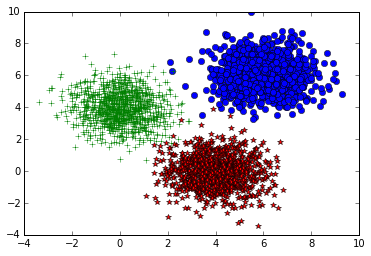

In [26]:
#HW 10.2 - Data Visualization
plt.plot(samples1[:, 0], samples1[:, 1],'*', color = 'red')
plt.plot(samples2[:, 0], samples2[:, 1],'o',color = 'blue')
plt.plot(samples3[:, 0], samples3[:, 1],'+',color = 'green')
plt.show()

In [27]:
#Calculate which class each data point belongs to
def nearest_centroid(line):
    x = np.array([float(f) for f in line.split(',')])
    closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()
    return (closest_centroid_idx,(x,1))

#plot centroids and data points for each iteration
def plot_iteration(means):
    plt.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    plt.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    plt.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue')
    plt.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    plt.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    plt.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    plt.show()

Iteration0
[[ 1.0213829   0.36632769]
 [ 3.90442045  2.56394766]
 [ 2.28725832  5.84281265]]


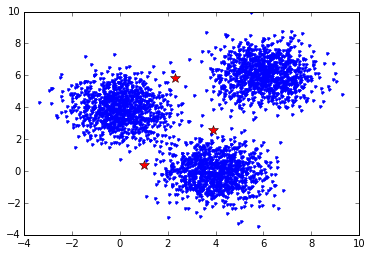

Iteration1
[[ 1.64329663  0.97558158]
 [ 5.11136252  2.07263368]
 [ 2.89860132  5.59751971]]


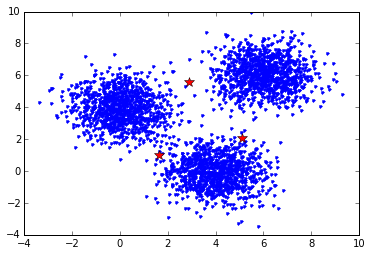

Iteration2
[[ 1.47430833  1.47865871]
 [ 5.32959845  1.48867669]
 [ 3.55568812  5.75268634]]


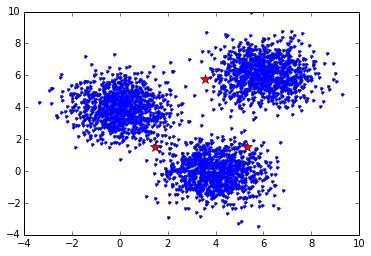

Iteration3
[[ 0.68553619  2.60076368]
 [ 4.66888294  0.2216114 ]
 [ 4.90624466  6.01177758]]


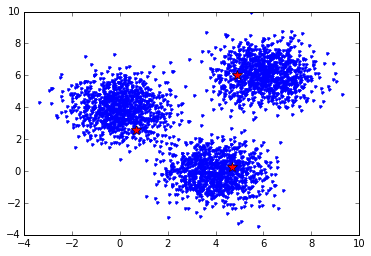

Iteration4
[[ 0.0634966   3.88964314]
 [ 4.04029088 -0.08009097]
 [ 5.98439803  6.10866112]]


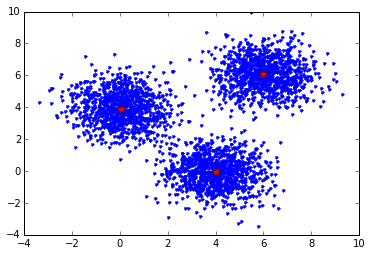

Iteration5
[[ 0.0309563   3.97903379]
 [ 3.98828179 -0.04842114]
 [ 6.01898184  6.11034861]]


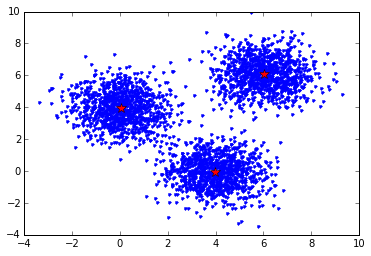

Iteration6
[[ 0.02712147  3.98324631]
 [ 3.98421324 -0.04459177]
 [ 6.01898184  6.11034861]]


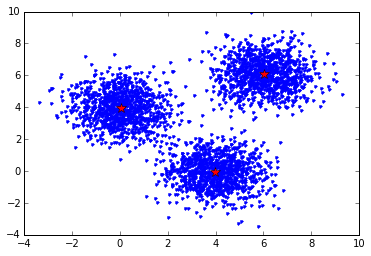

Final Results:
[[ 0.02712147  3.98324631]
 [ 3.98421324 -0.04459177]
 [ 6.01898184  6.11034861]]


In [28]:
K = 3
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

D = sc.textFile("./data.csv").cache()
iter_num = 0
for i in range(10):  
    res = D.map(nearest_centroid).reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect()
    #res [(0, (array([  2.66546663e+00,   3.94844436e+03]), 1001)  ), 
    #     (2, (array([ 6023.84995923,  5975.48511018]), 1000)), 
    #     (1, (array([ 3986.85984761,    15.93153464]), 999))]
    # res[1][1][1] returns 1000 here
    res = sorted(res,key = lambda x : x[0])  #sort based on clusted ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  #divide by cluster size
    if np.sum(np.absolute(centroids_new-centroids))<0.01:
        break
    print "Iteration" + str(iter_num)
    iter_num = iter_num + 1 
    centroids = centroids_new
    print centroids
    plot_iteration(centroids)
print "Final Results:"
print centroids

##HW 10.4

###HW 10.4 - Problem Statement
Using the KMeans code (homegrown code) provided repeat the experiments in HW10.3. Comment on any differences between the results in HW10.3 and HW10.4. Explain.

## End of Submission